In [2]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

Pull in Stock Data

In [57]:
# TODO: enter your ETF ticker, dates, and price interval
# set parameters for data pull
ticker = 'SPY'

# access data and display
df_etf = yf.download(ticker, interval='1d', period='max')

# Calculate daily returns [(new / old) - 1]
df_etf['ret'] = ((df_etf['Adj Close'] / df_etf['Adj Close'].shift()) - 1) * 100
df_etf = df_etf.reindex(columns=['Adj Close', 'ret'])

[*********************100%%**********************]  1 of 1 completed


Pull in Risk Free, FOMC Dates, Federal Funds Target Rate

In [58]:
# Pull in Fama/French 3 Factors [Daily] csv file
df_rf = pd.read_csv('RF.csv', skiprows=3, index_col=0, skipfooter=1)
df_rf.index = pd.to_datetime(df_rf.index, format='%Y%m%d', errors='coerce')
df_rf['RF'] /= 100

# Merge risk-free rate and etf data 
df_all = pd.merge(df_rf, df_etf, left_index=True, right_index=True, how='inner').dropna()
df_all.drop(['Mkt-RF', 'SMB', 'HML'], axis=1, inplace=True)

# Calculate excess returns
df_all['xs_ret'] = df_all['ret'] - df_all['RF']

# Pull in provided fomc data
df_fomc = pd.read_csv('FOMC_DATES.csv', index_col='Date')

# Reformat dates
df_fomc.index = pd.to_datetime(df_fomc.index, format='%Y%m%d', errors='coerce')

# Merge fomc dates
df_all = pd.merge(df_all, df_fomc, left_index=True, right_index=True, how='left')
df_all['fomc'] = df_all['fomc'].fillna(0)

# Reset index and make date column
df_all.index.name = 'Date'

# Pull Federal Funds Rate
df_ir = pd.read_csv('DFEDTAR.csv')
df_ir['Date'] = pd.to_datetime(df_ir['Date'])
df_ir.set_index('Date', inplace=True)

# Manipulate Federal Funds Rate
df_ir = df_ir.rename(columns={'interest rate': 'rate_after'})
df_ir['rate_before'] = df_ir['rate_after'].shift(1)
conditions = [
    (df_ir['rate_after'] > df_ir['rate_before']),
    (df_ir['rate_after'] < df_ir['rate_before']),
    (df_ir['rate_after'] == df_ir['rate_before'])
]
actions = ['raise', 'lower', 'nothing']
df_ir['action'] = np.select(conditions, actions, default='unknown')
df_all = pd.merge(df_all, df_ir, left_index=True, right_index=True, how='left')

# Pull VIX
df_vix = pd.read_csv('VIX.csv')
df_vix['Date'] = pd.to_datetime(df_vix['Date'])
df_vix.set_index('Date', inplace=True)
df_vix = df_vix.rename(columns={'Adj Close': 'VIX Adj Close'})
df_vix = df_vix.reindex(['VIX Adj Close'], axis=1)
df_vix['VIX Change'] = ((df_vix['VIX Adj Close'] / df_vix['VIX Adj Close'].shift()) - 1) * 100
df_all = pd.merge(df_all, df_vix, left_index=True, right_index=True, how='left')

df_all


C:\Users\andre\AppData\Local\Temp\ipykernel_19880\1978636867.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_rf = pd.read_csv('RF.csv', skiprows=3, index_col=0, skipfooter=1)


,RF,Adj Close,ret,xs_ret,fomc,rate_after,rate_before,action,VIX Adj Close,VIX Change
Date,,,,,,,,,,
1993-02-01,0.00012,25.118788,0.711216,0.711096,0.0,NaN,NaN,NaN,12.33,-0.724638
1993-02-02,0.00012,25.172010,0.211884,0.211764,0.0,NaN,NaN,NaN,12.25,-0.648824
1993-02-03,0.00012,25.438097,1.057073,1.056953,0.0,NaN,NaN,NaN,12.12,-1.061224
1993-02-04,0.00012,25.544533,0.418411,0.418291,0.0,NaN,NaN,NaN,12.29,1.402640
1993-02-05,0.00012,25.526783,-0.069486,-0.069606,0.0,NaN,NaN,NaN,12.90,4.963385
...,...,...,...,...,...,...,...,...,...,...
2023-07-25,0.00022,453.839142,0.273004,0.272784,0.0,5.25,5.25,nothing,13.86,-0.359454
2023-07-26,0.00022,453.908905,0.015372,0.015152,1.0,5.25,5.25,nothing,13.19,-4.834055
2023-07-27,0.00022,450.899506,-0.662996,-0.663216,0.0,5.50,5.25,raise,14.41,9.249431


In [62]:
# replot of buy date vs sell date with bubbles being the size of the return

#INPUTS
buy_days = [x -14 for x in range(29)]
sell_days = [x -14 for x in range(29)]

#OUTPUS
x = []
y = []
z = []

for buy_day in buy_days:
  for sell_day in sell_days:
    if buy_day == sell_day:
      continue
    if buy_day > sell_day:
      continue

    # Create buy and sell columns
    df_all['buy'] = df_all['fomc'].shift(buy_day)
    df_all['sell'] = df_all['fomc'].shift(sell_day)

    # Calculate Sharpe Ratio
    num_days = abs(buy_day - sell_day)
    scale = num_days * 8

    df_result = df_all.query('sell == 1 or buy == 1')
    df_result['buy_price'] = df_result['Adj Close'].shift(1)
    df_result['strat_ret'] = (df_result['Adj Close'] / df_result['buy_price']) - 1
    df_result['strat_xs_ret'] = df_result['strat_ret'] - df_result['RF']

    mean = df_result['strat_xs_ret'].mean() 
    stdev = df_result['strat_xs_ret'].std()

    sharpe = (mean / stdev) # Not scaled
    df_result

    x.append(buy_day)
    y.append(sell_day)
    z.append(sharpe)
    

C:\Users\andre\AppData\Local\Temp\ipykernel_19880\3680101576.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['buy_price'] = df_result['Adj Close'].shift(1)
C:\Users\andre\AppData\Local\Temp\ipykernel_19880\3680101576.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['strat_ret'] = (df_result['Adj Close'] / df_result['buy_price']) - 1
C:\Users\andre\AppData\Local\Temp\ipykernel_19880\3680101576.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Text(0.5, 1.0, 'Sharpe Ratio for Buy vs Sell Day for SPY')

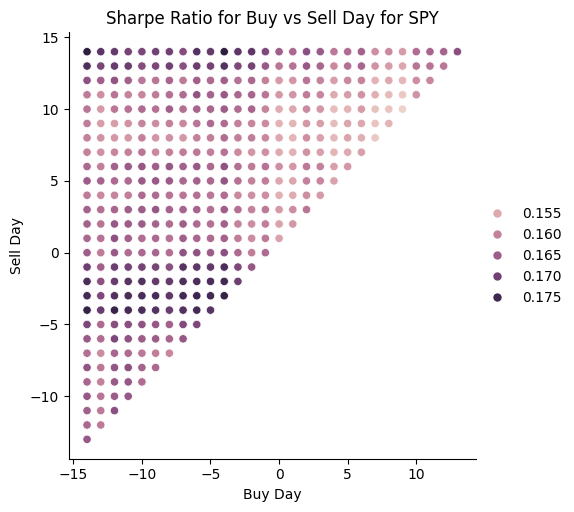

In [63]:
sns.relplot(x=x, y=y, hue=z)
plt.xlabel("Buy Day")
plt.ylabel("Sell Day")
plt.title(f"Sharpe Ratio for Buy vs Sell Day for {ticker}")

In [61]:
best_days = pd.DataFrame({'buy_day': x, 'sell_day': y, 'sharpe': z})
best_days.sort_values(by='sharpe', ascending=False)

,buy_day,sell_day,sharpe
794,14,-4,0.176816
307,-4,14,0.176816
27,-14,14,0.176698
784,14,-14,0.176698
318,-3,-4,0.175916
...,...,...,...
723,11,9,0.151342
637,8,7,0.151308
609,7,8,0.151308
695,10,9,0.150266
